In [1]:
#@title import dependencies
import os
import re
import gc
import json
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.sparse import coo_matrix
from sklearn.decomposition import NMF
from scipy.sparse.linalg import svds

np.random.seed(42)

# Dataset Downloading and Analysis

In [2]:
# @title Download dataset from Kaggle
import kagglehub

path = "/root/.cache/kagglehub/datasets/himanshuwagh/spotify-million/versions/1"
if not os.path.exists(path):
  # Download latest version
  path = kagglehub.dataset_download("himanshuwagh/spotify-million")

# contiene le slices del dataset: 1000 slice das 1000 playlist ciascuna
data: str = os.path.join(path, "data")

In [ ]:
# @title shuffle slices in a list and pick from them
shuffled_slices = np.array(os.listdir(data))
np.random.shuffle(shuffled_slices)

shuffled_slices[:3]

array(['mpd.slice.694000-694999.json', 'mpd.slice.946000-946999.json',
       'mpd.slice.18000-18999.json'], dtype='<U28')

# SVD Approach

## Dataset Handling

In [ ]:
million_df = pd.DataFrame()
num_training_files = 800

# Create an empty list to hold all rows as dictionaries
data_list = []
# uri_to_info = dict()

#for i, filename in tqdm(enumerate(sorted(os.listdir(data), key=extract_starting_number)[:num_training_files]), desc="Processing Slices"):
for i, filename in tqdm(enumerate(shuffled_slices[:num_training_files]), desc="Processing Slices", total = num_training_files):
    if filename.startswith("mpd.slice.") and filename.endswith(".json"):
        filepath = os.path.join(data, filename)

        with open(filepath, "r", encoding="utf-8") as jsonfile:
            cur_slice = json.load(jsonfile)

        # for playlist in tqdm(cur_slice["playlists"], desc="Processing playlist..."):
        for playlist in cur_slice["playlists"]:
            playlist_id = playlist["pid"]
            # num_tracks = playlist["num_tracks"]

            # Collect data for the playlist
            for track in playlist["tracks"]:
                data_list.append({
                    "playlist": playlist_id,
                    "track": track["track_uri"][14:]  # remove 'spotify:track:'
                })
                # if track["track_uri"][14:] not in uri_to_info:
                #   uri_to_info[track["track_uri"][14:]] = (track["artist_name"], track["track_name"])

    # update every 30 files for speedup
    if i%30 == 0:
        new_data = pd.DataFrame(data_list)
        data_list.clear()
        million_df = pd.concat([million_df, new_data], ignore_index=True)

# Convert the list of dictionaries into a DataFrame in one go
# dumb_dataset = pd.DataFrame(data_list)
new_data = pd.DataFrame(data_list)
data_list = []
million_df = pd.concat([million_df, new_data], ignore_index=True)

million_df["playlist"] = million_df["playlist"].astype("int32")

# save uri_to_info
# with open("uri_to_info.json", "w") as f:
#   json.dump(uri_to_info, f)

# del uri_to_info
# gc.collect()

Processing Slices: 100%|██████████| 800/800 [12:39<00:00,  1.05it/s]


In [ ]:
million_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53096018 entries, 0 to 53096017
Data columns (total 2 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   playlist  int32 
 1   track     object
dtypes: int32(1), object(1)
memory usage: 607.6+ MB


In [ ]:
million_df

playlist                   track
0           694000  00NUqFMIpCsrYPbM9YpVHQ
1           694000  3Eq7yD58dIXqOgw1j7NFhY
2           694000  6FFLxBDwKXhvIPAu29TceY
3           694000  2QLWLAqMMJuiBRztcBFgvM
4           694000  1kMuU3TNQvHbqvXCWBodmP
...            ...                     ...
53096013    285999  11XOct4BuKOTKPbeu4lLqx
53096014    285999  1Ww2X89SP4AuRAMvLKdR8h
53096015    285999  0zgczixdffm7x8QKeNf8zx
53096016    285999  2aFsnosXpluT9cXwsXkt50
53096017    285999  77oqmXUNY4yGrmLDZHfyER

[53096018 rows x 2 columns]

<Axes: xlabel='Number of Tracks', ylabel='Number of Playlists'>

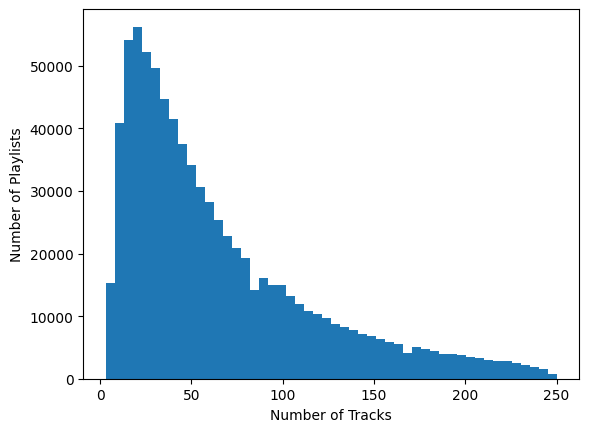

In [ ]:
# @title How many playlists share the same number of tracks, and how many tracks are in them?
million_df.groupby("playlist")["track"].nunique().plot(kind="hist", bins=50, ylabel="Number of Playlists", xlabel="Number of Tracks")  # .sort_values().plot()

In [ ]:
playlist_counts = million_df.groupby("playlist")["track"].nunique()

min_track_num = 10
max_track_num = 150
valid_playlists = playlist_counts[(playlist_counts >= min_track_num) & (playlist_counts <= max_track_num)]

In [ ]:
playlist_counts.shape

(800000,)

In [ ]:
valid_playlists.shape

(697511,)

<Axes: ylabel='Frequency'>

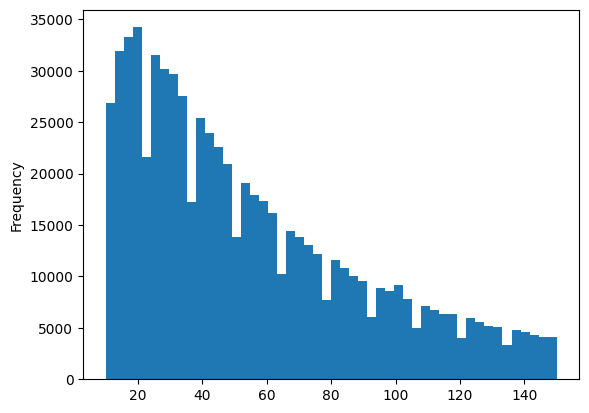

In [ ]:
valid_playlists.plot(kind="hist", bins=50)

In [ ]:
print(f"Before removing playlists: {million_df.shape = }")
million_df = million_df[million_df["playlist"].isin(valid_playlists.index)]
print(f"After removing playlists:  {million_df.shape = }")

Before removing playlists: million_df.shape = (53096018, 2)
After removing playlists:  million_df.shape = (38827460, 2)


<Axes: xlabel='Tracks', ylabel='Log Number of Playlist'>

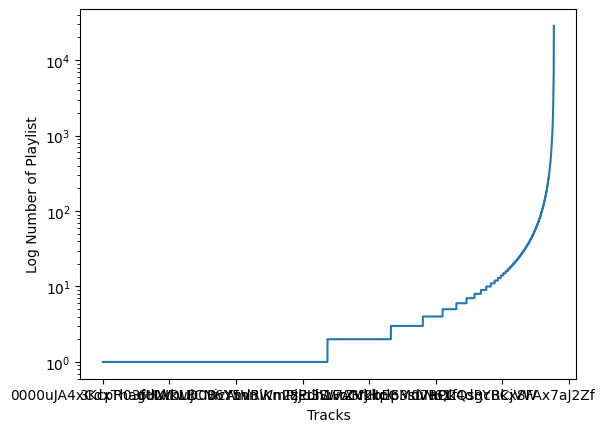

In [ ]:
# @title In how many playlists does each track appear?
million_df.groupby("track")["playlist"].nunique().sort_values().plot(logy=True, ylabel="Log Number of Playlist", xlabel="Tracks") # .plot(kind="hist", bins=50, )

In [ ]:
track_counts = million_df.groupby("track")["playlist"].nunique()

min_playlist_num = 50
max_playlist_num = np.inf
valid_tracks = track_counts[(track_counts >= min_playlist_num) & (track_counts <= max_playlist_num)]

In [ ]:
track_counts.shape

(1694250,)

In [ ]:
valid_tracks.shape

(77335,)

In [ ]:
print(f"Before removing tracks: {million_df.shape = }")
million_df = million_df[million_df["track"].isin(valid_tracks.index)]
print(f"After removing tracks: {million_df.shape = }")

Before removing tracks: million_df.shape = (38827460, 2)
After removing tracks: million_df.shape = (31993530, 2)


In [ ]:
playlist_id_to_idx = {id: idx for idx, id in enumerate(million_df["playlist"].unique())}
track_uri_to_idx = {uri: idx for idx, uri in enumerate(million_df["track"].unique())}

million_df["playlist_idx"] = million_df["playlist"].map(playlist_id_to_idx)
million_df["track_idx"] = million_df["track"].map(track_uri_to_idx)

# Create COO matrix
rows = million_df["playlist_idx"]
cols = million_df["track_idx"]
data_list = np.ones(len(million_df))  # All entries are 1 since a track belongs to a playlist

csr_rating_matrix = coo_matrix((data_list, (rows, cols)), shape=(len(playlist_id_to_idx), len(track_uri_to_idx))).tocsr()


print(csr_rating_matrix.shape)

(692283, 77335)


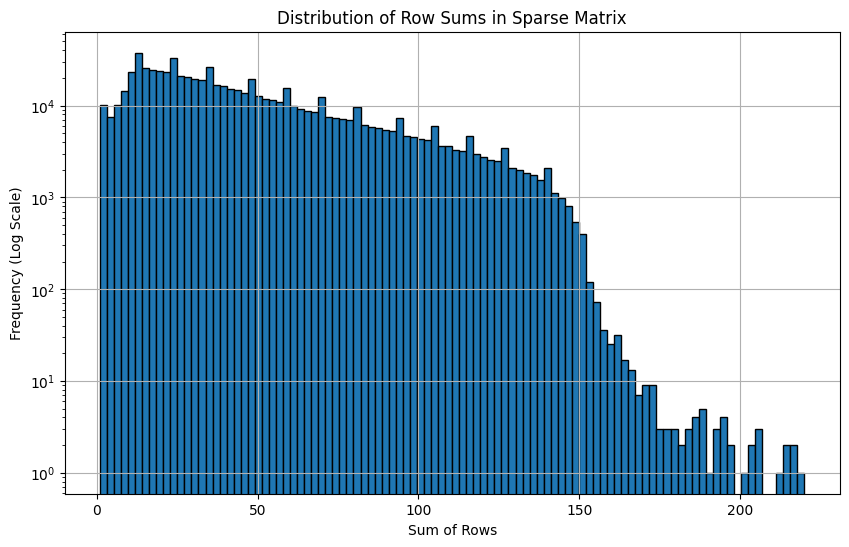

In [ ]:
import matplotlib.pyplot as plt

row_sums = np.array(csr_rating_matrix.sum(axis=1)).flatten()  # Convert to 1D NumPy array

# Plot the distribution of row sums
plt.figure(figsize=(10, 6))
plt.hist(row_sums, bins=100, log=True, edgecolor="black")  # Log scale for better visualization
plt.xlabel("Sum of Rows")
plt.ylabel("Frequency (Log Scale)")
plt.title("Distribution of Row Sums in Sparse Matrix")
plt.grid(True)
plt.show()

In [ ]:
# Step 1: Compute row sums
row_sums = np.array(csr_rating_matrix.sum(axis=1)).flatten()

# Step 2: Filter rows where sum >= 25
valid_rows = np.where(row_sums >= 25)[0]  # Get indices of valid rows

# Step 3: Randomly shuffle valid rows
np.random.shuffle(valid_rows)  # Shuffle row indices

# Step 4: Select only valid rows from CSR matrix
filtered_permuted_matrix = csr_rating_matrix[valid_rows, :]

filtered_permuted_matrix = filtered_permuted_matrix[:100000,:]

# Check the new shape
print("Original shape:", csr_rating_matrix.shape)
print("Filtered & permuted shape:", filtered_permuted_matrix.shape)

Original shape: (692283, 77335)
Filtered & permuted shape: (100000, 77335)


### old code

In [ ]:
# Count how many playlists each track appears in
track_frequency = million_df.groupby("track")["playlist"].nunique()
total_songs = len(track_frequency)

# Convert to a DataFrame for easier handling
track_frequency_df = track_frequency.reset_index().rename(columns={"playlist": "playlist_count"})

# Total number of playlists
# total_playlists = million_df["playlist_id"].nunique()
total_playlists = 1000*num_training_files

# threshold
# min_thresh = np.percentile(total_songs, 5)  # Mantieni le tracce sopra il 5° percentile
# max_thresh = np.percentile(total_songs, 95)  # Mantieni le tracce sotto il 95° percentile
min_thresh = 0
max_thresh = 2000000

# Filter tracks that appear in at least the threshold number of playlists
popular_tracks = track_frequency_df[(track_frequency_df["playlist_count"] <= max_thresh) & (track_frequency_df["playlist_count"] >= min_thresh)]

partial = len(popular_tracks)

# Extract popular track IDs
popular_track_ids = popular_tracks["track"].tolist()

# Filter the original dataset
filtered_df = million_df[million_df["track"].isin(popular_track_ids)]

<Axes: xlabel='track'>

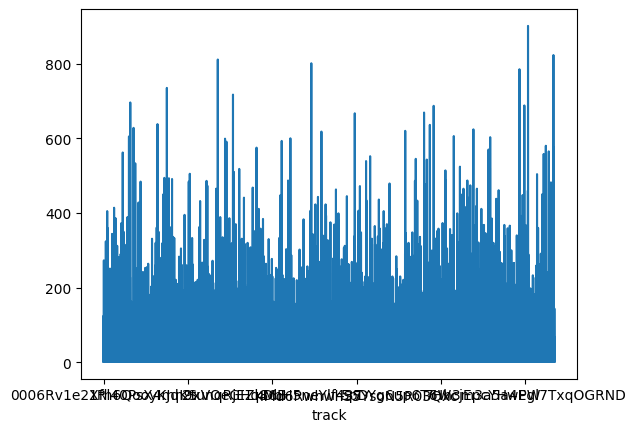

In [ ]:
track_frequency.plot()

In [ ]:
print("Minumum number of playlists: ", threshold)
ratio = partial / total_songs
print("Total songs: ", total_songs)
print(f"Songs that appear in at least {threshold} playlists: ", partial)
print(f"Ratio: {ratio:.2f}")

Minumum number of playlists:  40
Total songs:  1435339
Songs that appear in at least 40 playlists:  70308
Ratio: 0.05


In [ ]:
print("Songs with most appearences in playlists: ")
for uri, playlist in zip(track_frequency_df.sort_values("playlist_count", ascending=False).head()["track"], track_frequency_df.sort_values("playlist_count", ascending=False).head()["playlist_count"]):
  artist, name = uri_to_info[uri]
  print(f"{artist} - {name} (Appears in {playlist} playlists, {playlist/total_playlists:.2f}% of total playlist in the training set)")

Songs with most appearences in playlists: 
Kendrick Lamar - HUMBLE. (Appears in 18187 playlists, 0.05% of total playlist in the training set)
Drake - One Dance (Appears in 16660 playlists, 0.04% of total playlist in the training set)
DRAM - Broccoli (feat. Lil Yachty) (Appears in 16479 playlists, 0.04% of total playlist in the training set)
The Chainsmokers - Closer (Appears in 16194 playlists, 0.04% of total playlist in the training set)
Post Malone - Congratulations (Appears in 15898 playlists, 0.04% of total playlist in the training set)


In [ ]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1329548 entries, 0 to 1329547
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   playlist  1329548 non-null  int32 
 1   track     1329548 non-null  object
dtypes: int32(1), object(1)
memory usage: 15.2+ MB


In [ ]:
filtered_df.shape

(1329548, 2)

In [ ]:
# Make an explicit copy of filtered_df
filtered_df = filtered_df.copy()

# Map playlist_id and track_id to numerical indices
playlist_id_to_idx = {id: idx for idx, id in enumerate(filtered_df["playlist"].unique())}
track_uri_to_idx = {uri: idx for idx, uri in enumerate(filtered_df["track"].unique())}

filtered_df["playlist_idx"] = filtered_df["playlist"].map(playlist_id_to_idx)
filtered_df["track_idx"] = filtered_df["track"].map(track_uri_to_idx)

# Create COO matrix
rows = filtered_df["playlist_idx"]
cols = filtered_df["track_idx"]
data_list = np.ones(len(filtered_df))  # All entries are 1 since a track belongs to a playlist

csr_rating_matrix = coo_matrix((data_list, (rows, cols)), shape=(len(playlist_id_to_idx), len(track_uri_to_idx)))


print(csr_rating_matrix.shape)

(20000, 267186)


### continua

In [ ]:
num_tracks = csr_rating_matrix.shape[1]
tracks = set(track_uri_to_idx.keys())

# prova TfIDF
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer(norm='l2', use_idf=True)
tfidf_matrix = tfidf.fit_transform(csr_rating_matrix)

tfidf = TfidfTransformer(norm='l2', use_idf=True)
tfidf_filtered_permuted_matrix = tfidf.fit_transform(filtered_permuted_matrix)

In [ ]:
# @title save for ram runtime errors

with open("csr_rating_matrix.pkl", "wb") as f:
  pickle.dump(csr_rating_matrix, f)

with open("tfidf_matrix.pkl", "wb") as f:
  pickle.dump(tfidf_matrix, f)

with open("filtered_permuted_matrix.pkl", "wb") as f:
  pickle.dump(filtered_permuted_matrix, f)

with open("tfidf_filtered_permuted_matrix.pkl", "wb") as f:
  pickle.dump(tfidf_filtered_permuted_matrix, f)

with open("shuffled_slices.pkl", "wb") as f:
  pickle.dump(shuffled_slices, f)

with open("track_uri_to_idx.pkl", "wb") as f:
  pickle.dump(track_uri_to_idx, f)

with open("num_training_files.pkl", "wb") as f:
  pickle.dump(num_training_files, f)

In [15]:
# @title load for ram runtime errors
with open("csr_rating_matrix.pkl", "rb") as f:
  csr_rating_matrix = pickle.load(f)

with open("tfidf_matrix.pkl", "rb") as f:
  tfidf_matrix = pickle.load(f)

with open("filtered_permuted_matrix.pkl", "rb") as f:
  filtered_permuted_matrix = pickle.load(f)

with open("tfidf_filtered_permuted_matrix.pkl", "rb") as f:
  tfidf_filtered_permuted_matrix = pickle.load(f)

with open("shuffled_slices.pkl", "rb") as f:
  shuffled_slices = pickle.load(f)

with open("track_uri_to_idx.pkl", "rb") as f:
  track_uri_to_idx = pickle.load(f)

with open("num_training_files.pkl", "rb") as f:
  num_training_files = pickle.load(f)

num_tracks = csr_rating_matrix.shape[1]
tracks = set(track_uri_to_idx.keys())

In [ ]:
# @title free ram
# del uri_to_info
del million_df
del(playlist_counts, valid_playlists)
del(track_counts, valid_tracks)
# del track_frequency_df
# del filtered_df
del(rows, cols, data_list, new_data)
# del(popular_tracks, popular_track_ids)
del playlist_id_to_idx
# del track_frequency
try:
  del(row_sums, valid_rows)
except:
  pass
gc.collect()

19444

In [ ]:
gc.collect()

20

(477620, 70046)


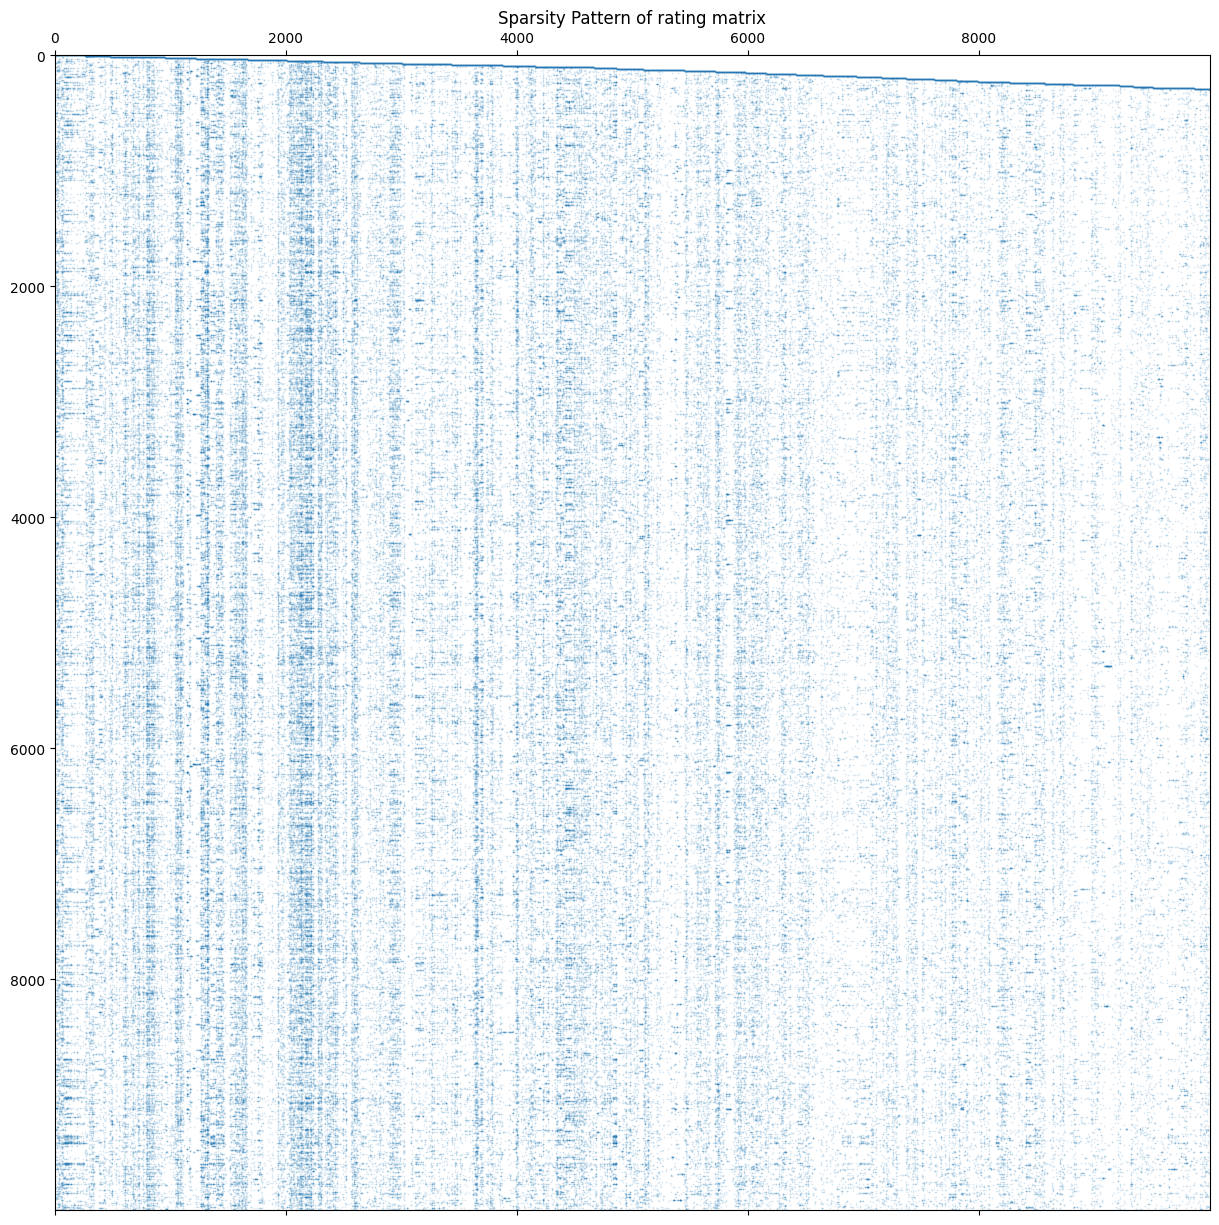

In [ ]:
# Plot the sparsity pattern
import matplotlib.pyplot as plt
print(csr_rating_matrix.shape)

plt.figure(figsize=(15,15))
plt.spy(csr_rating_matrix.tocsr()[:10000, :10000], markersize=0.05)
plt.title("Sparsity Pattern of rating matrix")
plt.show()

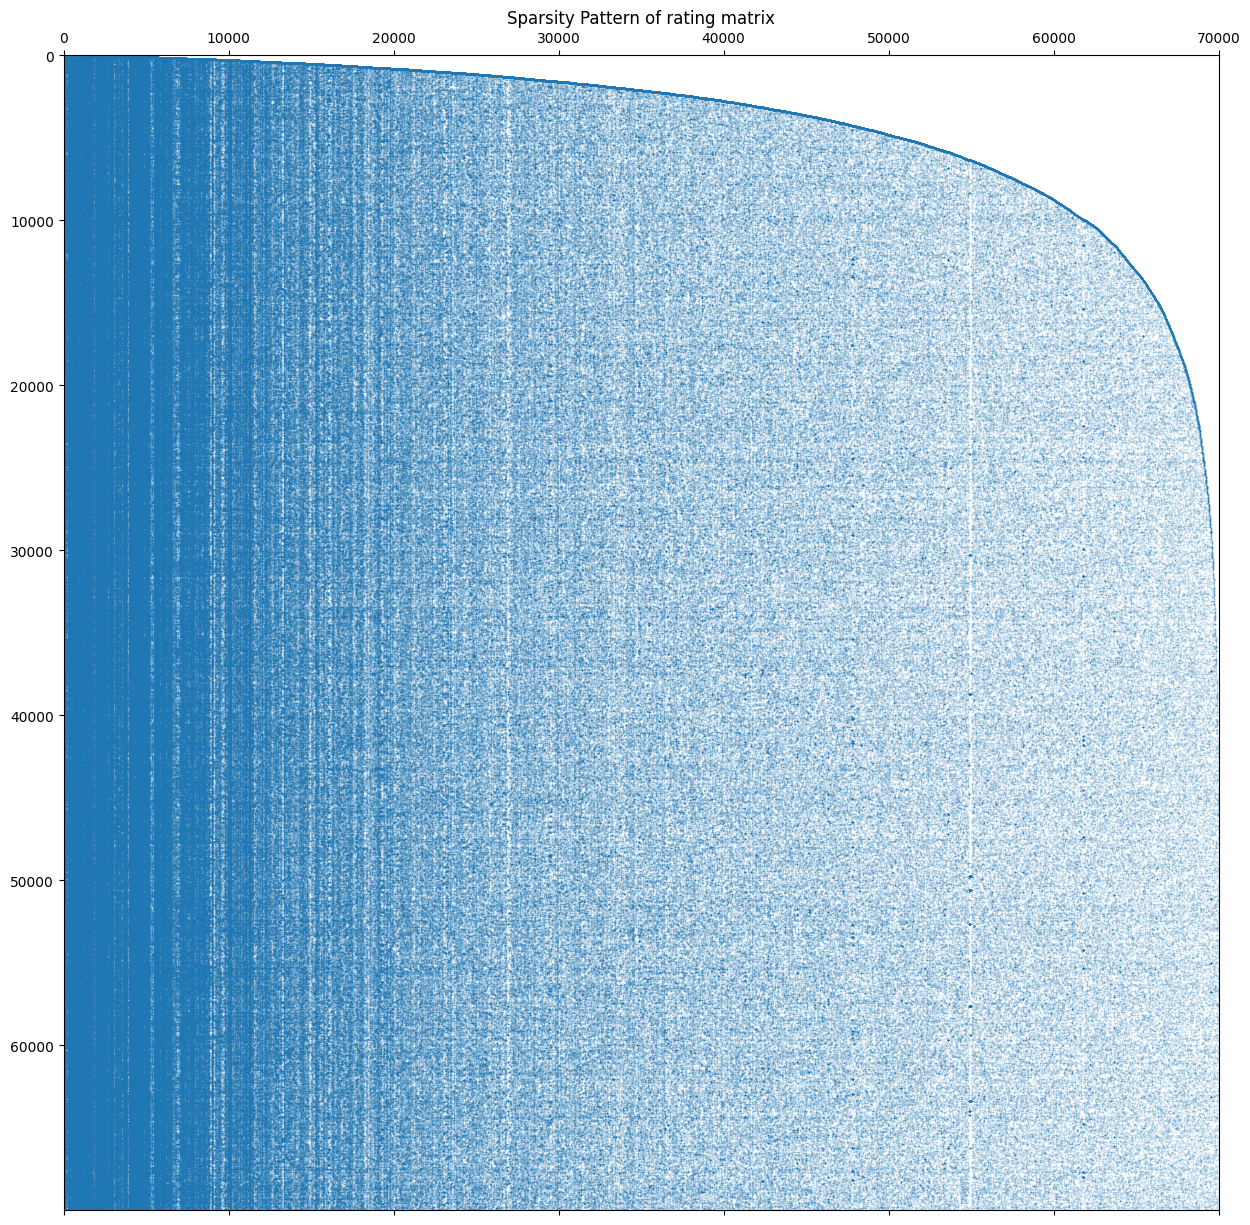

In [ ]:
plt.figure(figsize=(15,15))
plt.spy(tfidf_matrix.tocsr()[:70000], markersize=0.05)
plt.title("Sparsity Pattern of rating matrix")
plt.show()

## Training

In [4]:
class ScipySVD():
  def __init__(self, n_components, **kwargs):
    self.n_components = n_components
    self.kwargs = kwargs


  def fit(self, X):
    _, _, components_ = svds(X, self.n_components, **self.kwargs)
    self.components_ = components_


  def transform(self, X):
    return X @ self.components_.T

### SVD Models

In [5]:
# @title SVD model on binary rating matrix
svd_model = ScipySVD(500, random_state=42)
svd_model.fit(csr_rating_matrix)  # .tocsr()[30_000:32_000,:])

with open("svd_model.pkl", "wb") as f:
  pickle.dump(svd_model, f)

In [6]:
# @title SVD model on TfIDF rating matrix
svd_model_tfidf = ScipySVD(500, random_state=42)
svd_model_tfidf.fit(tfidf_matrix)

# save model
with open("svd_model_tfidf.pkl", "wb") as f:
  pickle.dump(svd_model_tfidf, f)

In [7]:
# @title SVD model on permuted and sampled rating matrix
svd_model_permuted = ScipySVD(500, random_state=42)
svd_model_permuted.fit(filtered_permuted_matrix)

# save model
with open("svd_model_permuted.pkl", "wb") as f:
  pickle.dump(svd_model_permuted, f)

In [8]:
# @title SVD model on tfidf permuted and sampled rating matrix
svd_model_permuted_tfidf = ScipySVD(500, random_state=42)
svd_model_permuted_tfidf.fit(tfidf_filtered_permuted_matrix)

# save model
with open("svd_model_permuted_tfidf.pkl", "wb") as f:
  pickle.dump(svd_model_permuted_tfidf, f)

### RMF Models (not working)

In [ ]:
# @title Regularized Matrix Factorization Model

class RMF:
    def __init__(self, num_features=50, alpha=0.01, beta=0.01, epochs=1000):
        """
        R: Playlist-track interaction matrix (numpy array)
        num_features: Number of latent features
        alpha: Learning rate
        beta: Regularization strength
        epochs: Number of training iterations
        """
        self.num_playlists, self.num_tracks = total_playlists, num_tracks
        self.num_features = num_features
        self.alpha = alpha
        self.beta = beta
        self.epochs = epochs

        # Initialize latent feature matrices (small random values)
        self.P = np.random.normal(scale=1. / num_features, size=(self.num_playlists, num_features))
        self.Q = np.random.normal(scale=1. / num_features, size=(self.num_tracks, num_features))

        # Initialize biases
        self.b_p = np.zeros(self.num_playlists)  # Playlist biases
        self.b_t = np.zeros(self.num_tracks)  # Track biases

    def fit(self, R):
        """
        Train the model using Stochastic Gradient Descent (SGD)
        """
        self.b = np.mean(R[np.where(R > 0)])  # Global bias
        samples = [(p, t) for p in range(self.num_playlists) for t in range(self.num_tracks) if R[p, t] > 0]

        for epoch in range(self.epochs):
            np.random.shuffle(samples)  # Shuffle samples for stochastic updates

            for p, t in samples:
                # Calculate prediction with bias terms
                prediction = self.b + self.b_p[p] + self.b_t[t] + np.dot(self.P[p, :], self.Q[t, :].T)
                error = R[p, t] - prediction  # Error term

                # Update biases
                self.b_p[p] += self.alpha * (error - self.beta * self.b_p[p])
                self.b_t[t] += self.alpha * (error - self.beta * self.b_t[t])

                # Update latent factors
                P_temp = self.P[p, :]  # Store original value before updating
                self.P[p, :] += self.alpha * (error * self.Q[t, :] - self.beta * self.P[p, :])
                self.Q[t, :] += self.alpha * (error * P_temp - self.beta * self.Q[t, :])

            # Compute total loss with regularization
            loss = 0
            for p, t in samples:
                prediction = self.b + self.b_p[p] + self.b_t[t] + np.dot(self.P[p, :], self.Q[t, :].T)
                loss += (R[p, t] - prediction) ** 2

            loss += self.beta * (np.sum(self.P**2) + np.sum(self.Q**2) + np.sum(self.b_p**2) + np.sum(self.b_t**2))

            print(f"Epoch {epoch + 1}/{self.epochs} - Loss: {loss:.4f}")

    def transform(self):
        """
        Generate predicted playlist-track interaction matrix
        """
        return self.b + self.b_p[:, np.newaxis] + self.b_t + np.dot(self.P, self.Q.T)


In [ ]:
rmf_model = RMF(num_features=20, alpha=0.01, beta=0.01, epochs=100)
rmf_model.fit(csr_rating_matrix.tocsr())

# save model
with open("rmf_model.pkl", "wb") as f:
  pickle.dump(rmf_model, f)

In [ ]:
rmf_model_tfidf = RMF(num_features=20, alpha=0.01, beta=0.01, epochs=100)
rmf_model_tfidf.fit(tfidf_matrix)

# save model
with open("rmf_model_tfidf.pkl", "wb") as f:
  pickle.dump(rmf_model_tfidf, f)

### NMF Models

In [ ]:
# @title NMF model on binary rating matrix
nmf_model = NMF(70, random_state=42)
nmf_model.fit(csr_rating_matrix)

# save model
with open("nmf_model.pkl", "wb") as f:
  pickle.dump(nmf_model, f)

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [ ]:
# @title NMF model on TfIDF rating matrix
nmf_model_tfidf = NMF(70, random_state=42)
nmf_model_tfidf.fit(tfidf_matrix)

# save model
with open("nmf_model_tfidf.pkl", "wb") as f:
  pickle.dump(nmf_model_tfidf, f)

## Validation

In [9]:
# @title metrics definition
def precision_at_k(predicted_matrix, ground_truth_matrix, input_matrix, k):
    """
    Calculate precision at k while excluding items that are already in the input matrix (playlist).

    Args:
    - predicted_matrix (np.ndarray): Matrix of predicted scores for each song in the playlist.
    - ground_truth_matrix (np.ndarray): Ground truth matrix with binary values indicating relevant songs.
    - input_matrix (np.ndarray): Matrix representing songs already in the playlist (binary).
    - k (int): The number of top items to consider.

    Returns:
    - float: The average precision at k, excluding already present songs.
    """
    # Create a mask for already existing items (input matrix)
    mask = input_matrix > 0  # 1 indicates the item is already in the playlist

    # Mask the predicted scores for already existing items by setting them to -inf
    masked_predictions = np.where(mask, -np.inf, predicted_matrix)

    # Use argsort to get the indices of the top k predictions after masking
    top_k_indices = np.argsort(masked_predictions, axis=1)[:, ::-1][:, :k]

    # Extract relevant items in ground truth corresponding to the top k predictions
    relevant_items = ground_truth_matrix[np.arange(ground_truth_matrix.shape[0])[:, None], top_k_indices]

    # Calculate precision as the number of relevant items divided by k
    precision_scores = np.sum(relevant_items, axis=1) / k

    # Return the average precision
    return np.mean(precision_scores)



def recall_at_k(predicted_matrix, ground_truth_matrix, input_matrix, k):
    # Mask the predictions where the input matrix has 1s (already in the playlist)
    mask = input_matrix > 0
    masked_predictions = np.where(mask, -np.inf, predicted_matrix)

    # Get the indices of the top k predictions for each row after masking
    top_k_indices = np.argsort(masked_predictions, axis=1)[:, -k:][:, ::-1]

    # Gather the relevant items in ground truth corresponding to top k predictions
    relevant_items = ground_truth_matrix[np.arange(ground_truth_matrix.shape[0])[:, None], top_k_indices]

    # Calculate the recall for each playlist
    total_relevant = np.sum(ground_truth_matrix, axis=1)  # Total relevant items per playlist

    # Avoid division by zero: mask rows with no relevant items
    recall_scores = np.sum(relevant_items, axis=1) / np.maximum(total_relevant, 1)

    # Return the mean recall, ignoring rows with no relevant items
    return np.mean(recall_scores[total_relevant > 0])



def mean_reciprocal_rank(predicted_matrix, ground_truth_matrix, input_matrix):
    reciprocal_ranks = []

    # Iterate over each playlist (row in the matrix)
    for pred_row, true_row, input_row in zip(predicted_matrix, ground_truth_matrix, input_matrix):
        # Mask the predictions where the input matrix has 1s (already in the playlist)
        mask = input_row == 1
        masked_predictions = np.where(mask, -np.inf, pred_row)

        # Get the indices sorted by predicted scores in descending order
        sorted_indices = np.argsort(masked_predictions)[::-1]

        # Find the rank of the first relevant item
        found_relevant = False
        for rank, index in enumerate(sorted_indices, start=1):
            if true_row[index] == 1:  # If the item is relevant in the ground truth
                reciprocal_ranks.append(1 / rank)
                found_relevant = True
                break

        # If no relevant items were found, append 0
        if not found_relevant:
            reciprocal_ranks.append(0)

    # Return the mean of the reciprocal ranks
    return np.mean(reciprocal_ranks)




In [10]:
#@title evaluating functions definition
def evaluate_model_k_tracks_removed_df(model, k, num_valid_files=10):
  """
  evaluate model processing a slice of playlists, 200 playlist at time to avoid
  colab cpu overflow
  """

  precision_at_10 = np.zeros(num_valid_files)
  precision_at_5 = np.zeros(num_valid_files)
  precision_at_2 = np.zeros(num_valid_files)
  precision_at_1 = np.zeros(num_valid_files)

  recall_at_10 = np.zeros(num_valid_files)
  recall_at_5 = np.zeros(num_valid_files)
  recall_at_2 = np.zeros(num_valid_files)
  recall_at_1 = np.zeros(num_valid_files)

  mrr = np.zeros(num_valid_files)

  for file_idx, filename in enumerate(shuffled_slices[num_training_files:num_training_files+num_valid_files]):
    correct_playlists = np.zeros((1000, num_tracks))
    p_counter = -1
    if filename.startswith("mpd.slice.") and filename.endswith(".json"):
      filepath = os.path.join(data, filename)

      with open(filepath, "r", encoding="utf-8") as jsonfile:
        cur_slice = json.load(jsonfile)

      for playlist in cur_slice["playlists"]:
        p_counter += 1

        for track in playlist["tracks"]:
          track_uri = track["track_uri"][14:]

          if track_uri in tracks:
            t_idx = track_uri_to_idx[track_uri]

            correct_playlists[p_counter, t_idx] = 1


    incomplete_playlists = np.copy(correct_playlists)

    # Turn exactly k ones to zeros per row
    for row in incomplete_playlists:
      # Get the indices of ones in the current row
      one_indices = np.where(row == 1)[0]

      if len(one_indices) >= k:
        indices_to_zero = np.random.choice(one_indices, size=k, replace=False)
        row[indices_to_zero] = 0

    # delete rows with less then k elements
    row_sums = np.sum(incomplete_playlists, axis=1)
    valid_rows = np.where(row_sums >= k)[0]  # Extract valid row indices

    incomplete_playlists = incomplete_playlists[valid_rows,:]
    correct_playlists = correct_playlists[valid_rows,:]

    n_iter = 5

    cur_precision_at_10 = [0 for _ in range(n_iter)]
    cur_precision_at_5 = [0 for _ in range(n_iter)]
    cur_precision_at_2 = [0 for _ in range(n_iter)]
    cur_precision_at_1 = [0 for _ in range(n_iter)]

    cur_recall_at_10 = [0 for _ in range(n_iter)]
    cur_recall_at_5 = [0 for _ in range(n_iter)]
    cur_recall_at_2 = [0 for _ in range(n_iter)]
    cur_recall_at_1 = [0 for _ in range(n_iter)]

    cur_mrr = [0 for _ in range(n_iter)]

    size_batch = correct_playlists.shape[0] // n_iter

    for iter in range(n_iter):
      input_matrix_iter = incomplete_playlists[size_batch*iter:size_batch*(iter+1), :]
      P_new = model.transform(input_matrix_iter)

      # Predici la matrice ricostruita per le nuove playlist
      predicted_matrix = np.dot(P_new, model.components_)

      ground_truth_matrix_iter = correct_playlists[size_batch*iter:size_batch*(iter+1), :]

      cur_precision_at_10[iter] = precision_at_k(predicted_matrix, ground_truth_matrix_iter, input_matrix_iter, 10)
      cur_precision_at_5[iter] = precision_at_k(predicted_matrix, ground_truth_matrix_iter, input_matrix_iter, 5)
      cur_precision_at_2[iter] = precision_at_k(predicted_matrix, ground_truth_matrix_iter, input_matrix_iter, 2)
      cur_precision_at_1[iter] = precision_at_k(predicted_matrix, ground_truth_matrix_iter, input_matrix_iter, 1)

      cur_recall_at_10[iter] = recall_at_k(predicted_matrix, ground_truth_matrix_iter, input_matrix_iter, 10)
      cur_recall_at_5[iter] = recall_at_k(predicted_matrix, ground_truth_matrix_iter, input_matrix_iter, 5)
      cur_recall_at_2[iter] = recall_at_k(predicted_matrix, ground_truth_matrix_iter, input_matrix_iter, 2)
      cur_recall_at_1[iter] = recall_at_k(predicted_matrix, ground_truth_matrix_iter, input_matrix_iter, 1)

      cur_mrr[iter] = mean_reciprocal_rank(predicted_matrix, ground_truth_matrix_iter, input_matrix_iter)

    precision_at_10[file_idx] = np.mean(cur_precision_at_10)
    precision_at_5[file_idx] = np.mean(cur_precision_at_5)
    precision_at_2[file_idx] = np.mean(cur_precision_at_2)
    precision_at_1[file_idx] = np.mean(cur_precision_at_1)
    recall_at_10[file_idx] = np.mean(cur_recall_at_10)
    recall_at_5[file_idx] = np.mean(cur_recall_at_5)
    recall_at_2[file_idx] = np.mean(cur_recall_at_2)
    recall_at_1[file_idx] = np.mean(cur_recall_at_1)
    mrr[file_idx] = np.mean(cur_mrr)

  print("  Precision@10 = ",np.mean(precision_at_10))
  print("  Precision@5 = ",np.mean(precision_at_5))
  print("  Precision@2 = ",np.mean(precision_at_2))
  print("  Precision@1 = ",np.mean(precision_at_1))

  print("  Recall@10 = ",np.mean(recall_at_10))
  print("  Recall@5 = ",np.mean(recall_at_5))
  print("  Recall@2 = ",np.mean(recall_at_2))
  print("  Recall@1 = ",np.mean(recall_at_1))

  print("  MRR = ", np.mean(mrr))




def evaluate_model_k_tracks_per_playlist(model, k, num_valid_files=10):
  """
  evaluate model processing a slice of playlists, 200 playlist at time to avoid
  colab cpu overflow
  """

  # num_valid_files = 1000 - num_training_files
  precision_at_10 = np.zeros(num_valid_files)
  precision_at_5 = np.zeros(num_valid_files)
  precision_at_2 = np.zeros(num_valid_files)
  precision_at_1 = np.zeros(num_valid_files)

  recall_at_10 = np.zeros(num_valid_files)
  recall_at_5 = np.zeros(num_valid_files)
  recall_at_2 = np.zeros(num_valid_files)
  recall_at_1 = np.zeros(num_valid_files)

  mrr = np.zeros(num_valid_files)

  for file_idx, filename in enumerate(shuffled_slices[num_training_files:num_training_files+num_valid_files]):
    correct_playlists = np.zeros((1000, num_tracks))
    p_counter = -1
    if filename.startswith("mpd.slice.") and filename.endswith(".json"):
      filepath = os.path.join(data, filename)

      with open(filepath, "r", encoding="utf-8") as jsonfile:
        cur_slice = json.load(jsonfile)

      for playlist in cur_slice["playlists"]:
        p_counter += 1

        for track in playlist["tracks"]:
          track_uri = track["track_uri"][14:]

          if track_uri in tracks:
            t_idx = track_uri_to_idx[track_uri]

            correct_playlists[p_counter, t_idx] = 1


    incomplete_playlists = np.copy(correct_playlists)

    for row in incomplete_playlists:
      one_indexes = np.where(row == 1)[0]

      if len(one_indexes) >= k:
        indices_to_zero = np.random.choice(one_indexes, size=(len(one_indexes)-k), replace=False)
        row[indices_to_zero] = 0

    n_iter = 5

    cur_precision_at_10 = [0 for _ in range(n_iter)]
    cur_precision_at_5 = [0 for _ in range(n_iter)]
    cur_precision_at_2 = [0 for _ in range(n_iter)]
    cur_precision_at_1 = [0 for _ in range(n_iter)]

    cur_recall_at_10 = [0 for _ in range(n_iter)]
    cur_recall_at_5 = [0 for _ in range(n_iter)]
    cur_recall_at_2 = [0 for _ in range(n_iter)]
    cur_recall_at_1 = [0 for _ in range(n_iter)]

    cur_mrr = [0 for _ in range(n_iter)]

    size_batch = 1000 // n_iter

    for iter in range(n_iter):
      input_matrix_iter = incomplete_playlists[size_batch*iter:size_batch*(iter+1), :]
      P_new = model.transform(input_matrix_iter)

      # Predici la matrice ricostruita per le nuove playlist
      predicted_matrix = np.dot(P_new, model.components_)

      ground_truth_matrix_iter = correct_playlists[size_batch*iter:size_batch*(iter+1), :]

      cur_precision_at_10[iter] = precision_at_k(predicted_matrix, ground_truth_matrix_iter, input_matrix_iter, 10)
      cur_precision_at_5[iter] = precision_at_k(predicted_matrix, ground_truth_matrix_iter, input_matrix_iter, 5)
      cur_precision_at_2[iter] = precision_at_k(predicted_matrix, ground_truth_matrix_iter, input_matrix_iter, 2)
      cur_precision_at_1[iter] = precision_at_k(predicted_matrix, ground_truth_matrix_iter, input_matrix_iter, 1)

      cur_recall_at_10[iter] = recall_at_k(predicted_matrix, ground_truth_matrix_iter, input_matrix_iter, 10)
      cur_recall_at_5[iter] = recall_at_k(predicted_matrix, ground_truth_matrix_iter, input_matrix_iter, 5)
      cur_recall_at_2[iter] = recall_at_k(predicted_matrix, ground_truth_matrix_iter, input_matrix_iter, 2)
      cur_recall_at_1[iter] = recall_at_k(predicted_matrix, ground_truth_matrix_iter, input_matrix_iter, 1)

      cur_mrr[iter] = mean_reciprocal_rank(predicted_matrix, ground_truth_matrix_iter, input_matrix_iter)

    precision_at_10[file_idx] = np.mean(cur_precision_at_10)
    precision_at_5[file_idx] = np.mean(cur_precision_at_5)
    precision_at_2[file_idx] = np.mean(cur_precision_at_2)
    precision_at_1[file_idx] = np.mean(cur_precision_at_1)
    recall_at_10[file_idx] = np.mean(cur_recall_at_10)
    recall_at_5[file_idx] = np.mean(cur_recall_at_5)
    recall_at_2[file_idx] = np.mean(cur_recall_at_2)
    recall_at_1[file_idx] = np.mean(cur_recall_at_1)
    mrr[file_idx] = np.mean(cur_mrr)

  print("  Precision@10 = ",np.mean(precision_at_10))
  print("  Precision@5 = ",np.mean(precision_at_5))
  print("  Precision@2 = ",np.mean(precision_at_2))
  print("  Precision@1 = ",np.mean(precision_at_1))

  print("  Recall@10 = ",np.mean(recall_at_10))
  print("  Recall@5 = ",np.mean(recall_at_5))
  print("  Recall@2 = ",np.mean(recall_at_2))
  print("  Recall@1 = ",np.mean(recall_at_1))

  print("  MRR = ", np.mean(mrr))

### Validation Dataset

In [ ]:
valid_df = pd.DataFrame()
num_valid_files = 1000 - num_training_files

# Create an empty list to hold all rows as dictionaries
data_list = []
# uri_to_info = dict()

#for i, filename in tqdm(enumerate(sorted(os.listdir(data), key=extract_starting_number)[:num_training_files]), desc="Processing Slices"):
for i, filename in tqdm(enumerate(shuffled_slices[num_training_files:]), desc="Processing Slices", total=num_valid_files):
    if filename.startswith("mpd.slice.") and filename.endswith(".json"):
        filepath = os.path.join(data, filename)

        with open(filepath, "r", encoding="utf-8") as jsonfile:
            cur_slice = json.load(jsonfile)

        # for playlist in tqdm(cur_slice["playlists"], desc="Processing playlist..."):
        for playlist in cur_slice["playlists"]:
            playlist_id = playlist["pid"]
            # num_tracks = playlist["num_tracks"]

            # Collect data for the playlist
            for track in playlist["tracks"]:
                track_uri = track["track_uri"][14:]

                if track_uri in tracks:
                    data_list.append({
                        "playlist": playlist_id,
                        "track": track_uri,
                    })
                # if track["track_uri"][14:] not in uri_to_info:
                #   uri_to_info[track["track_uri"][14:]] = (track["artist_name"], track["track_name"])

    # update every 30 files for speedup
    if i%30 == 0:
        new_data = pd.DataFrame(data_list)
        data_list.clear()
        valid_df = pd.concat([valid_df, new_data], ignore_index=True)

# Convert the list of dictionaries into a DataFrame in one go
# dumb_dataset = pd.DataFrame(data_list)
new_data = pd.DataFrame(data_list)
data_list = []
valid_df = pd.concat([valid_df, new_data], ignore_index=True)

valid_df["playlist"] = valid_df["playlist"].astype("int32")

In [ ]:
playlist_id_to_idx = {id: idx for idx, id in enumerate(valid_df["playlist"].unique())}

valid_df["playlist_idx"] = valid_df["playlist"].map(playlist_id_to_idx)
valid_df["track_idx"] = valid_df["track"].map(track_uri_to_idx)

# Create COO matrix
rows = valid_df["playlist_idx"]
cols = valid_df["track_idx"]
data_list = np.ones(len(valid_df))  # All entries are 1 since a track belongs to a playlist

csr_valid_matrix = coo_matrix((data_list, (rows, cols)), shape=(len(playlist_id_to_idx), len(track_uri_to_idx))).tocsr()


print(csr_valid_matrix.shape)

### Models

In [14]:
csr_rating_matrix.shape

(477620, 70046)

In [17]:
models = [
  # svd_model,
  svd_model_tfidf,
  svd_model_permuted,
  svd_model_permuted_tfidf,
  # nmf_model,
  # nmf_model_tfidf,
  # rmf_model,
  # rmf_model_tfidf,
]

In [ ]:
for k in [2, 5, 15, 30]:
  print(f"\nValidation Metrics Keeping {k} songs per playlist:")
  for i, model in enumerate(models, 1):
    print(f"  · model {i}: ", repr(model))
    evaluate_model_k_tracks_per_playlist(model, k, num_valid_files=1)
    # evaluate_model_k_tracks_per_playlist(nmf_model, k, num_valid_files=2)
    print()


Validation Metrics Keeping 2 songs per playlist:
  · model 1:  <__main__.ScipySVD object at 0x781c2f782d50>
  Precision@10 =  0.1911
  Precision@5 =  0.2192
  Precision@2 =  0.2495
  Precision@1 =  0.266
  Recall@10 =  0.04691051428329014
  Recall@5 =  0.027154222820049832
  Recall@2 =  0.013214881624566549
  Recall@1 =  0.007027133055928172
  MRR =  0.3830797947648207

  · model 2:  <__main__.ScipySVD object at 0x781c2fe254d0>
  Precision@10 =  0.18649999999999997
  Precision@5 =  0.21660000000000004
  Precision@2 =  0.2525
  Precision@1 =  0.273
  Recall@10 =  0.04317021641494052
  Recall@5 =  0.025063073248219787
  Recall@2 =  0.012147440281260052
  Recall@1 =  0.006750243505247175
  MRR =  0.3819628760192012

  · model 3:  <__main__.ScipySVD object at 0x781c2f997750>
  Precision@10 =  0.1867
  Precision@5 =  0.2162
  Precision@2 =  0.2535
  Precision@1 =  0.273
  Recall@10 =  0.04465568152026867
  Recall@5 =  0.026602723588175413
  Recall@2 =  0.012527607204243545
  Recall@1 =  0.

In [ ]:
for k in [0, 2, 5, 15, 30]:
  print(f"\n Validation Metrics Removing {k} songs:")
  evaluate_model_k_tracks_removed_df(svd_model, k, 2)
  print()

# Language Model Approach